In [70]:
# Librerías
import pandas as pd
import numpy as np
import re
from scipy.stats import norm, uniform
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# Carga de datos
pd.options.display.max_columns = None  # Mostrar todas las columnas
df = pd.read_csv('Data/Lending_Club_accepted_2007_to_2018Q4.csv', low_memory = False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,3600.00,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,24700.00,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,N

In [3]:
df.shape

(2260701, 151)

In [4]:
# Verificamos el estado de los préstamos
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [5]:
# Trabajaremos solo con los estados de "cumplido" e "incumplido" para crear el modelo de regresión más adelante
def limpiar_estado(estado):
    if estado in ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']:
        # Cummplido
        return 1
    elif estado in ['Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off']:
        # Incumplido
        return 0
    else:
        # En curso - Default, In Grace Period
        return 2
df['loan_status_2'] = df['loan_status'].apply(limpiar_estado)
df[['loan_status_2']]

,loan_status_2
0,1
1,1
2,1
3,2
4,1
...,...
2260696,2
2260697,0
2260698,2
2260699,2


In [6]:
df = df[df['loan_status_2'] != 2]
df.shape

(1373875, 152)

In [7]:
# Verificamos la columna term que se refiere a la duración del préstamo
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [8]:
# Eliminamos los valores NaN de la columna term
df = df.dropna(subset=['term'])

In [9]:
# Obtenemos solo los numéros
df['term'] = df['term'].apply(lambda x: int(re.sub("[^0-9]", "", x)))
df[['term']].head()

,term
0,36
1,36
2,60
4,60
5,36


In [10]:
# Variables de entrada
tasa_interes = df['int_rate']
duracion_prestamo = df['term']
puntaje_credito = df['fico_range_low']
monto_prestamo = df['loan_amnt']

# Mostrar variables de entrada
df[['int_rate', 'term', 'fico_range_low', 'loan_amnt']].head()

,int_rate,term,fico_range_low,loan_amnt
0,13.99,36,675.0,3600.0
1,11.99,36,715.0,24700.0
2,10.78,60,695.0,20000.0
4,22.45,60,695.0,10400.0
5,13.44,36,690.0,11950.0


In [11]:
# Cartera de préstamos
cartera_prestamos = df['loan_amnt'].sum()
cartera_prestamos

19863609950.0

In [12]:
# Definimos la distribución de probabilidad de la tasa de interés como una distribución normal
media_tasa_interes = tasa_interes.mean()
std_tasa_interes = tasa_interes.std()
dist_tasa_interes = norm(loc = media_tasa_interes, scale = std_tasa_interes)
# dist_tasa_interes_rvs = dist_tasa_interes.rvs(10000)  # rvs = Random Variates

print(f"Media Tasa Interes: {media_tasa_interes}")
print(f"Desv. Estándar Tasa Interes: {std_tasa_interes}")

Media Tasa Interes: 13.285777410570969
Desv. Estándar Tasa Interes: 4.787376182911051


In [13]:
# Definimos la distribución de la duración del préstamo como una distribución uniforme
min_duracion = duracion_prestamo.min()
max_duracion = duracion_prestamo.max()
dist_duracion_prestamo = uniform(loc = min_duracion, scale = (max_duracion - min_duracion))
# dist_duracion_prestamo_rvs = dist_duracion_prestamo.rvs(10000)

print(f"Duración mínima: {min_duracion}")
print(f"Duración máxima: {max_duracion}")
# print(f"Distribución Uniforme Duración Préstamo: {dist_duracion_prestamo_rvs}")

Duración mínima: 36
Duración máxima: 60


In [14]:
# Definimos la distribución del puntaje de crédito como una distribución normal
media_puntaje_credito = puntaje_credito.mean()
std_puntaje_credito = puntaje_credito.std()
dist_puntaje_credito = norm(loc = media_puntaje_credito, scale = std_puntaje_credito)
# dist_puntaje_credito_rvs = dist_puntaje_credito.rvs(10000)

print(f"Media Puntaje Crédito: {media_puntaje_credito}")
print(f"Desv. Estándar Puntaje Crédito: {std_puntaje_credito}")
# print(f"Distribución Normal Puntaje Crédito: {dist_puntaje_credito_rvs}")

Media Puntaje Crédito: 696.0926394322628
Desv. Estándar Puntaje Crédito: 31.80894134977668


In [60]:
# Definir la distribución del monto del préstamo como una distribución normal truncada a 0
media_monto_prestamo = monto_prestamo.mean()
std_monto_prestamo = monto_prestamo.std()
dist_monto_prestamo = norm(loc = media_monto_prestamo, scale = std_monto_prestamo).rvs(size=100000)
dist_monto_prestamo = dist_monto_prestamo.clip(0, None)

print(f"Media Monto Préstamo: {media_monto_prestamo}")
print(f"Desv. Estándar Monto Préstamo: {std_monto_prestamo}")
# print(f"Distribución Normal Monto Préstamo: {dist_monto_prestamo_rvs}")

Media Monto Préstamo: 14458.091129105633
Desv. Estándar Monto Préstamo: 8743.256237827445


In [61]:
# Creamos el modelo de regresión para calcular las variables 'beta' y 'alpha' y usarlos en la función de probabilidad de impago

# Seleccionamos las variables independientes
X = df[['int_rate', 'term', 'fico_range_low', 'loan_amnt']]

# Seleccionamos la variable dependiente
y = df['loan_status_2'] # Estado de préstamo | 1 = Cumplido & 0 = Incumplido

# Creamos y entrenamos el modelo de regresión logística
model = LogisticRegression(random_state = 21)
model.fit(X, y)

# Obtenemos los coeficientes de la regresión
beta = model.coef_[0]
alpha = model.intercept_[0]

print(f"Beta: {beta}\nAlpha: {alpha}")

Beta: [-1.00497478e-01 -2.01674039e-02  5.24272672e-03 -3.58470727e-06]
Alpha: -0.00043267820766461503


In [62]:
# Definimos la función de la probabilidad de impago utilizando 'alpha' y 'beta'
def prob_impago(int_rate, term, fico_range_low, loan_amnt):
    x = np.array([int_rate, term, fico_range_low, np.log(loan_amnt + 1e-8)])
    return 1 / (1 + np.exp(-(alpha + np.sum(x * beta))))

In [63]:
# Generar valores aleatorios para cada variable de entrada 
# utilizando la distribución de probabilidad definida
valores_tasa_interes = dist_tasa_interes.rvs(size=len(df))
valores_duracion_prestamo = dist_duracion_prestamo.rvs(size=len(df))
valores_puntaje_credito = dist_puntaje_credito.rvs(size=len(df))
valores_monto_prestamo = dist_monto_prestamo[np.random.randint(0, len(dist_monto_prestamo), size=len(df))]

# Calcular el riesgo de impago para cada préstamo utilizando la función definida
valores_probabilidad_impago = np.array([prob_impago(tasa, duracion, fico, monto) for tasa, duracion, fico, monto in zip(valores_tasa_interes, valores_duracion_prestamo, valores_puntaje_credito, valores_monto_prestamo)])
valores_probabilidad_impago

array([0.7549198 , 0.83041753, 0.79627782, ..., 0.58922665, 0.67151278,
       0.8453778 ])

In [64]:
# Calcular la cantidad esperada de impagos y la pérdida esperada por impagos
cantidad_esperada_impagos = np.sum(valores_probabilidad_impago * valores_monto_prestamo)
perdida_esperada_impagos = cantidad_esperada_impagos * 0.5 # supongamos que la pérdida promedio por impago es del 50%
fraccion_cartera_impagos_esperada = cantidad_esperada_impagos / cartera_prestamos

print(f'Cantidad esperada de impagos: $ {cantidad_esperada_impagos}')
print(f'Pérdida esperada por impagos: $ {perdida_esperada_impagos}', )
print('Fracción de la cartera de préstamos que se espera que sea impagada: {:.2%}'.format(fraccion_cartera_impagos_esperada))

Cantidad esperada de impagos: $ 15712358019.401695
Pérdida esperada por impagos: $ 7856179009.700848
Fracción de la cartera de préstamos que se espera que sea impagada: 79.10%


In [65]:
probabilidad_impago_cartera = valores_probabilidad_impago.mean()
print('La probabilidad de impago promedio de la cartera es: {:.2%}'.format(probabilidad_impago_cartera))

La probabilidad de impago promedio de la cartera es: 78.08%


In [66]:
# Lo agregamos al dataframe
df['prob_impago'] = valores_probabilidad_impago

In [67]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term,loan_status_2,prob_impago
0,68407277,NaN,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,leadman,10+ years,MORTGAGE,55000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.0,0.0,4421.723917,4421.72,3600.0,821.72,0.0,0.0,0.0,Jan-2019,122.67,NaN,Mar-2019,564.0,560.0,0.0,30.0,1.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN,1,0.754920
1,68355089,NaN,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,Engineer,10+ years,MORTGAGE,65000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.0,0.0,25679.660000,25679.66,24700.0,979.66,0.0,0.0,0.0,Jun-2016,926.35,NaN,Mar-2019,699.0,695.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,

In [78]:
# Calcular la tasa de interés promedio de la cartera
tasa_interes_promedio = np.mean(valores_tasa_interes)

# Calcular los ingresos totales
ingresos_totales = np.sum(valores_tasa_interes * valores_monto_prestamo)

# Calcular los costos totales
costos_impagos = perdida_esperada_impagos
costos_financiamiento = np.sum(valores_monto_prestamo) * 0.05
costos_totales = costos_impagos + costos_financiamiento

# Calcular el ROI
roi = (ingresos_totales - costos_totales) / costos_totales
print('Retorno de la inversión (ROI): {:.2%}'.format(roi))

Retorno de la inversión (ROI): 2918.06%


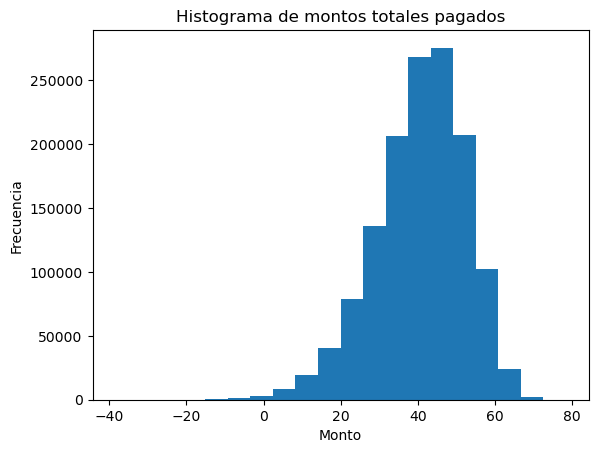

In [72]:
# Histograma de los montos totales pagados por todos los préstamos simulados
plt.hist(total_pagado, bins=20)
plt.title("Histograma de montos totales pagados")
plt.xlabel("Monto")
plt.ylabel("Frecuencia")
plt.show()

Text(0.5, 1.0, 'Distribución de los retornos de la inversión')

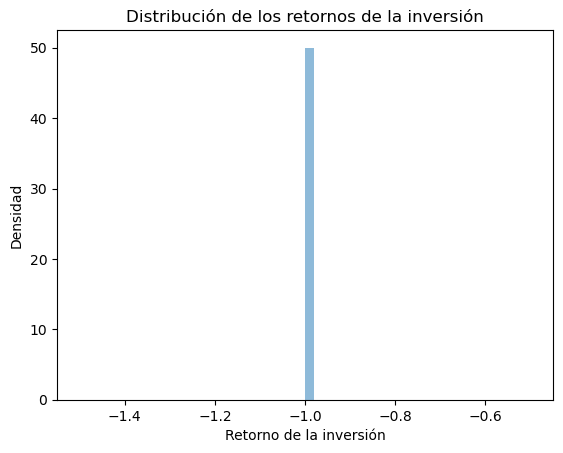

In [74]:
# Graficar histograma de los retornos de la inversión
fig, ax = plt.subplots()
ax.hist(roi, bins=50, density=True, alpha=0.5)
ax.set_xlabel('Retorno de la inversión')
ax.set_ylabel('Densidad')
ax.set_title('Distribución de los retornos de la inversión')

In [76]:
# Calcular estadísticos de los retornos de la inversión
media_roi = roi.mean()
std_roi = roi.std()
p10_roi = np.percentile(roi, 10)
p50_roi = np.percentile(roi, 50)
p90_roi = np.percentile(roi, 90)

In [77]:
# Imprimir resultados
print("Media del ROI:", media_roi)
print("Desviación estándar del ROI:", std_roi)
print("Percentil 10 del ROI:", p10_roi)
print("Percentil 50 del ROI:", p50_roi)
print("Percentil 90 del ROI:", p90_roi)

Media del ROI: -1.0000682843288753
Desviación estándar del ROI: 0.0
Percentil 10 del ROI: -1.0000682843288753
Percentil 50 del ROI: -1.0000682843288753
Percentil 90 del ROI: -1.0000682843288753
